## **Lab 2:** Foundations of Image Processing: Filtering and Fourier Analysis

**Objectives**
- Why filtering matters (denoising, edge detection, feature extraction).
- Implement convolution manually in Python (no cv2.filter2D initially).
- Mean/box filter, Gaussian filter, Compare their effects on noise vs edges.
- Fourier Transform of Images: Compute FFT, visualise magnitude spectrum, show correspondence between blur in spatial domain ↔ low-pass in frequency domain.
- Implement Sobel, Prewitt, Laplacian filters, Detect and visualise edges.
- Apply Gaussian blur of increasing sigma. Compare how derivatives degrade with more blur.
- Apply frame differencing for motion detection, low-pass filter video to reduce flicker.
- Exercises: Implement a custom filter kernel, Explore sharpening (unsharp mask). Design a filter that removes horizontal vs vertical patterns.

**Reading**

Book: Foundations of Computer Vision
- 15. Linear Image Filtering
- 16. Fourier Analysis
- 17. Blur Filters
- 18. Image Derivatives
- 19. Temporal Filters

**Instructions:**
> - Ensure your Python environment is setup correctly, in particular Jupyter package is installed.<br>As we progress through this module, you may be required to install additional packages.
> - Prior to this tutorial, read the entire notebook and attempt all coding exercises.
> - To complete the coding exercises, write some python code between<br>`### INPUT YOUR CODE HERE ###` and `### END OF YOUR CODE SEGMENT ###`.<br> Use provided hints where necessary. We will generally provide a rough estimate of the number of lines to write.
> - Run cells by pressing `Shift+Enter` and verify that your results are consistent with unit tests.
> - Submit completed notebook on VLE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, data, exposure, transform, filters, util, metrics, feature
import cv2
from scipy.signal import convolve2d
from scipy.ndimage import uniform_filter

import torch
import torch.nn.functional as F

print("Library versions:")
print("numpy:", np.__version__)
print("matplotlib:", plt.matplotlib.__version__)
print("cv2:", cv2.__version__)
print("pytorch:", torch.__version__)

# TODO: confirm you can run this cell without errors.

Library versions:
numpy: 2.0.2
matplotlib: 3.9.4
cv2: 4.12.0
pytorch: 2.6.0+cu118


## <font color='#D85658'>A. Introduction</font> ##

Why filtering matters (denoising, edge detection, feature extraction)?

Filtering is one of the core operations in image processing. By applying mathematical kernels or transformations to images, we can highlight important structures or suppress unwanted variations.
- **Denoising**: reduce random noise and improve image quality.
- **Edge detection**: emphasize boundaries that define shapes and objects.
- **Feature extraction**: prepare meaningful patterns for higher-level tasks in computer vision and AI.

In this section, we will explore how filtering provides the foundation for tasks ranging from simple enhancement to complex analysis such as recognition and classification.

### Exercise 1:

Real-world images often contain **noise** from sensors, compression, or poor lighting. Filtering can reduce this noise and make important structures clearer.  

Here, we add artificial noise to an image and then apply a **Gaussian blur filter** to smooth it. Notice how the filter reduces noise but also slightly blurs fine details — showing the trade-off in denoising. 

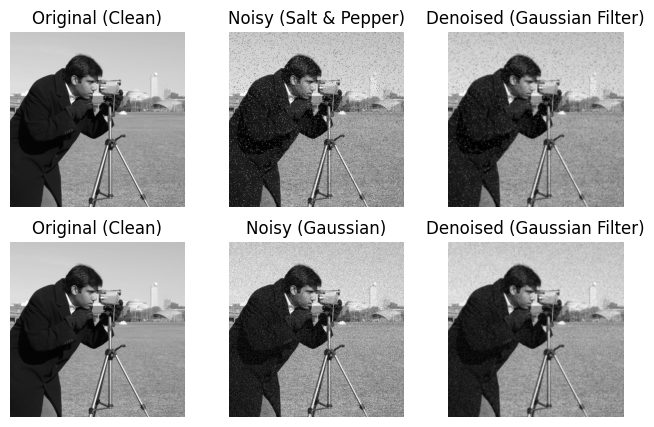

In [2]:
# --- Load a clean grayscale image ---
image = data.camera()

# --- Add artificial noise ---
### START CODE ### (2 lines)
noisy_sp = util.random_noise(image, mode="s&p", amount=0.05)
noisy_guss = util.random_noise(image, mode="gaussian", var=0.01)
### END CODE ###

# --- Apply Gaussian filter for denoising ---
### START CODE ### (2 lines)
denoised_sp = filters.gaussian(noisy_sp, sigma=1)
denoised_guss = filters.gaussian(noisy_guss, sigma=1)
### END CODE ###

# --- Display results side by side ---
fig, axes = plt.subplots(2, 3, figsize=(8, 5))

axes[0][0].imshow(image, cmap="gray")
axes[0][0].set_title("Original (Clean)")
axes[0][0].axis("off")

axes[0][1].imshow(noisy_sp, cmap="gray")
axes[0][1].set_title("Noisy (Salt & Pepper)")
axes[0][1].axis("off")

axes[0][2].imshow(denoised_sp, cmap="gray")
axes[0][2].set_title("Denoised (Gaussian Filter)")
axes[0][2].axis("off")

axes[1][0].imshow(image, cmap="gray")
axes[1][0].set_title("Original (Clean)")
axes[1][0].axis("off")

axes[1][1].imshow(noisy_guss, cmap="gray")
axes[1][1].set_title("Noisy (Gaussian)")
axes[1][1].axis("off")

axes[1][2].imshow(denoised_guss, cmap="gray")
axes[1][2].set_title("Denoised (Gaussian Filter)")
axes[1][2].axis("off")

plt.show()

> ***Expected Output:*** 6 Images 

### Exercise 2:
Edges correspond to **sudden changes in intensity**, which often mark object boundaries. Detecting edges helps computers recognize shapes and structures, making it a key step in many vision tasks.  

Here we compare different edge detection methods:  
- **Sobel**: emphasizes horizontal and vertical edges.  
- **Prewitt**: similar to Sobel but slightly simpler.  
- **Canny**: a more advanced method that detects clean, thin edges.

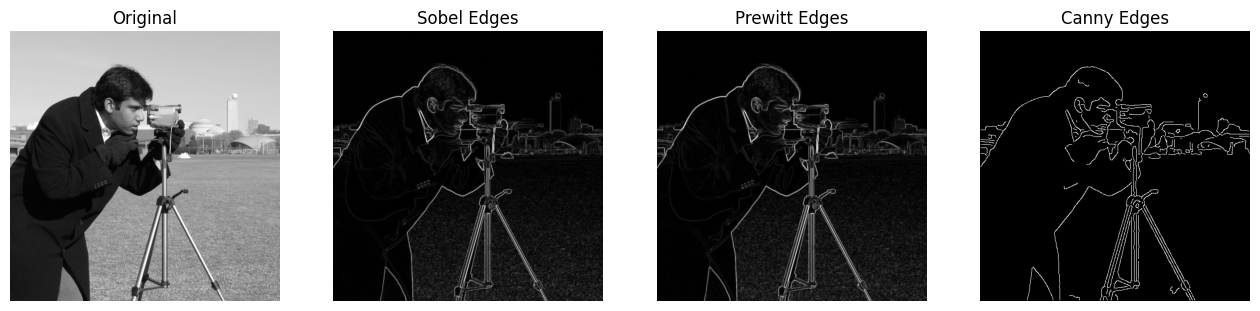

In [3]:
# --- Load a sample grayscale image ---
image = data.camera()

# --- Apply different edge detection methods ---
### START CODE ### (3 lines)
sobel_edges = filters.sobel(image)      # Sobel filter
prewitt_edges = filters.prewitt(image)    # Prewitt filter
canny_edges = feature.canny(image, sigma=2)      # Canny edge detector (sigma controls smoothing)
### END CODE ###

# --- Display original + edge-detected results ---
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(sobel_edges, cmap="gray")
axes[1].set_title("Sobel Edges")
axes[1].axis("off")

axes[2].imshow(prewitt_edges, cmap="gray")
axes[2].set_title("Prewitt Edges")
axes[2].axis("off")

axes[3].imshow(canny_edges, cmap="gray")
axes[3].set_title("Canny Edges")
axes[3].axis("off")

plt.show()

> ***Expected Output:*** 4 Images 

### Exercise 3: Feature Extraction with HOG (Histogram of Oriented Gradients)

Feature extraction transforms an image into a **set of meaningful patterns** that can be used for machine learning or AI tasks. Instead of working with raw pixels, we compute **descriptors** that capture shapes, textures, or edges.  

Here we use **Histogram of Oriented Gradients (HOG)**:  
- It divides the image into small regions (cells).  
- For each region, it counts edge orientations (gradient directions).  
- The result emphasizes **object structure** while ignoring unnecessary details like lighting.  

This prepares the image for tasks such as object detection or recognition.

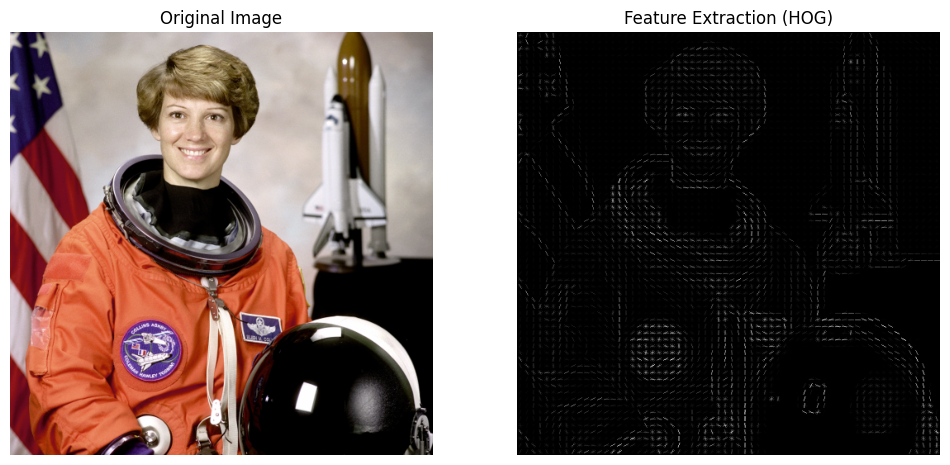

Extracted HOG feature vector length: 142884


In [4]:
# --- Load a sample grayscale image ---
image = data.astronaut()

gray_image = color.rgb2gray(image)  # convert to grayscale for feature extraction

# --- Compute HOG features and visualization ---

### START CODE ### (1 line)
hog_features, hog_image = feature.hog(
    gray_image, 
    pixels_per_cell=(8, 8), 
    cells_per_block=(2, 2), 
    visualize=True, 
    block_norm="L2-Hys"
)
### END CODE ###

# --- Display original image and HOG visualization ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

# The HOG visualization shows edges and patterns emphasized
axes[1].imshow(hog_image, cmap="gray")
axes[1].set_title("Feature Extraction (HOG)")
axes[1].axis("off")

plt.show()

print("Extracted HOG feature vector length:", len(hog_features))

> ***Expected Output:*** 2 Images 

## <font color='#D85658'>B. Convolution in 2D</font> ##

Implement convolution manually in Python (no cv2.filter2D initially).

### Exercise 4:

Convolution is the fundamental operation behind filtering. It works by sliding a **kernel (filter matrix)** across the image and computing weighted sums of pixel values.

In this exercise, we will:  
- Implement convolution manually with NumPy.  
- Apply it using a simple edge-detection kernel (Sobel-like).  
- Verify our results against PyTorch’s built-in convolution.

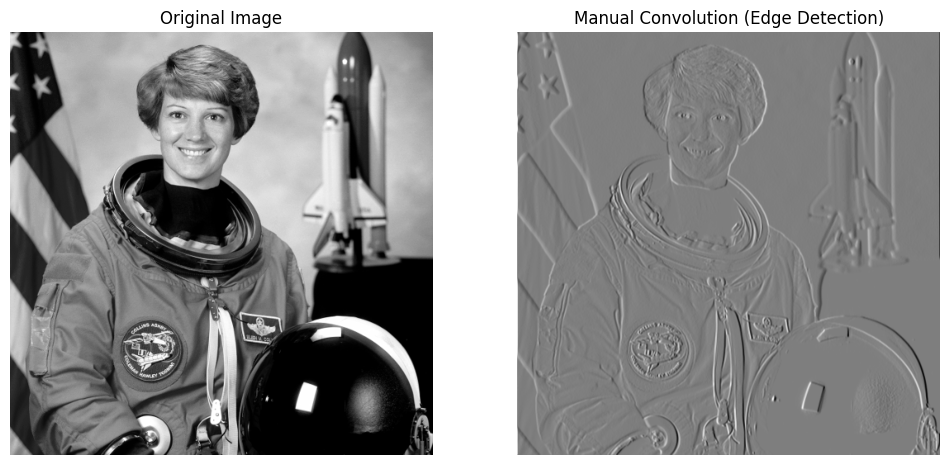

In [5]:
# --- Load grayscale test image ---
image = color.rgb2gray(data.astronaut())   # convert to grayscale

# --- Define a simple edge-detection kernel (Sobel-x like) ---
### START CODE ### (1 line)
kernel = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
### END CODE ###

# --- Manual convolution function ---
def conv2d_manual(img, kernel):
    kh, kw = kernel.shape
    ih, iw = img.shape
    
    # Output image (same size, so pad the input)
    pad_h, pad_w = kh // 2, kw // 2
    ### START CODE ### (2 lines)
    padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    output = np.zeros_like(img)
    ### END CODE ###
    
    # Convolution operation
    for i in range(ih):
        for j in range(iw):
            ### START CODE ### (2 lines)
            region = padded[i:i+kh, j:j+kw]
            output[i, j] = np.sum(region * kernel)
            ### END CODE ###
    return output

# --- Apply manual convolution ---
manual_edges = conv2d_manual(image, kernel)

# --- Show results ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(manual_edges, cmap="gray")
axes[1].set_title("Manual Convolution (Edge Detection)")
axes[1].axis("off")

plt.show()

> ***Expected Output:*** 2 Images 

Verification with PyTorch.

Mean absolute difference (manual vs PyTorch): 3.789518419574021e-08


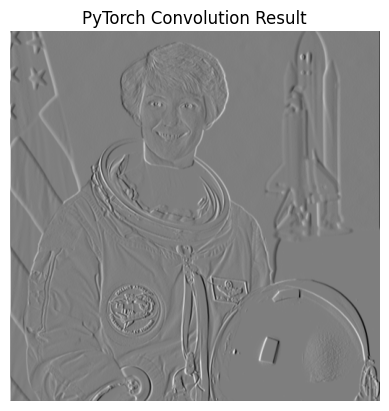

In [6]:
# Convert image and kernel to torch tensors
img_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # shape [1,1,H,W]
kernel_tensor = torch.tensor(kernel, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # shape [1,1,kH,kW]

# Apply convolution
### START CODE ### (2 lines)
conv_result = F.conv2d(img_tensor, kernel_tensor, padding=1)  # padding=1 for same size
conv_result = conv_result.squeeze().numpy()
### END CODE ###

# Compare manual vs. PyTorch
diff = np.abs(manual_edges - conv_result).mean()
print("Mean absolute difference (manual vs PyTorch):", diff)

# Show PyTorch result
plt.imshow(conv_result, cmap="gray")
plt.title("PyTorch Convolution Result")
plt.axis("off")
plt.show()

> ***Expected Output:*** 1 Image

## <font color='#D85658'>C. Linear Filters</font> ##

Explore a few linear filters: Mean/box filter, Gaussian filter. Compare their effects on noise vs edges.

### Exercise 5:

Linear filters apply a weighted average of nearby pixels to smooth an image. They are commonly used for **denoising**, but they affect edges differently:  

- **Mean (box) filter**: replaces each pixel with the average of its neighbors.  
  - Simple and effective for reducing random noise.  
  - Strongly blurs edges, since edges are also "averaged out."  

- **Gaussian filter**: applies a weighted average where closer pixels count more.  
  - Reduces noise while preserving edges better than a box filter.  
  - Mimics the effect of natural blurring (like a camera lens).  

Here we compare how these filters perform on a noisy image.

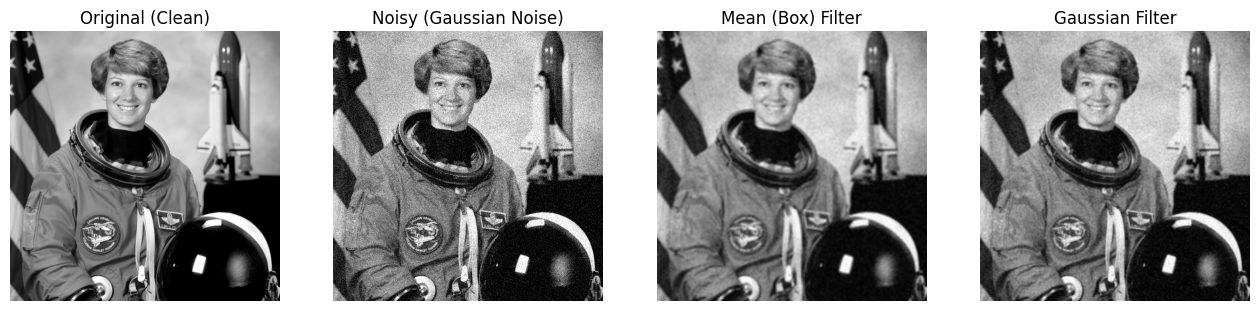

In [7]:
# --- Load a sample grayscale image ---
image = color.rgb2gray(data.astronaut())

# --- Add artificial Gaussian noise ---
noisy = util.random_noise(image, mode="gaussian", var=0.01)

# --- Apply Mean (box) filter ---
### START CODE ### (1 line)
mean_filtered = uniform_filter(noisy, size=5)  # 5x5 averaging window
### END CODE ###

# --- Apply Gaussian filter ---
### START CODE ### (1 line)
gaussian_filtered = filters.gaussian(noisy, sigma=1)  # sigma controls blur strength
### END CODE ###

# --- Display results ---
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original (Clean)")
axes[0].axis("off")

axes[1].imshow(noisy, cmap="gray")
axes[1].set_title("Noisy (Gaussian Noise)")
axes[1].axis("off")

axes[2].imshow(mean_filtered, cmap="gray")
axes[2].set_title("Mean (Box) Filter")
axes[2].axis("off")

axes[3].imshow(gaussian_filtered, cmap="gray")
axes[3].set_title("Gaussian Filter")
axes[3].axis("off")

plt.show()

> ***Expected Output:*** 4 Images

Reflection (Not needed to answer):
- Which filter removes noise more effectively?  
- Which filter preserves edges better?  
- Why might Gaussian filtering be more realistic than box filtering?  

With this setup, you should see the trade-off:
- Mean filter $\rightarrow$ stronger denoising, but edges are smeared.
- Gaussian filter $\rightarrow$ smoother, more natural look, with edges preserved better.

## <font color='#D85658'>D. Fourier Transform of Images</font> ##

In this section, we compute FFT and visualise magnitude spectrum. You will see correspondence between blur in spatial domain $\leftrightarrow$ low-pass in frequency domain, and experiment with two images and swapping phase/magnitude components.

The **Fourier Transform (FT)** decomposes an image into its frequency components.  

- Low frequencies: slow intensity variations (smooth regions, overall structure).  
- High frequencies: rapid intensity changes (edges, fine details).  

Key concepts:  
- Blurring in the **spatial domain** removes high frequencies $\rightarrow$ acts like a **low-pass filter**.  
- Sharpening in the **spatial domain** emphasizes high frequencies. 

### Exercise 6: 

In this exercise, we will:  
1. Compute the **2D FFT** of an image.  
2. Visualize the **magnitude spectrum**.  
3. Show how **blurring in the spatial domain** corresponds to **low-pass filtering** in the frequency domain.

##### Step 1: Compute FFT and Spectrum

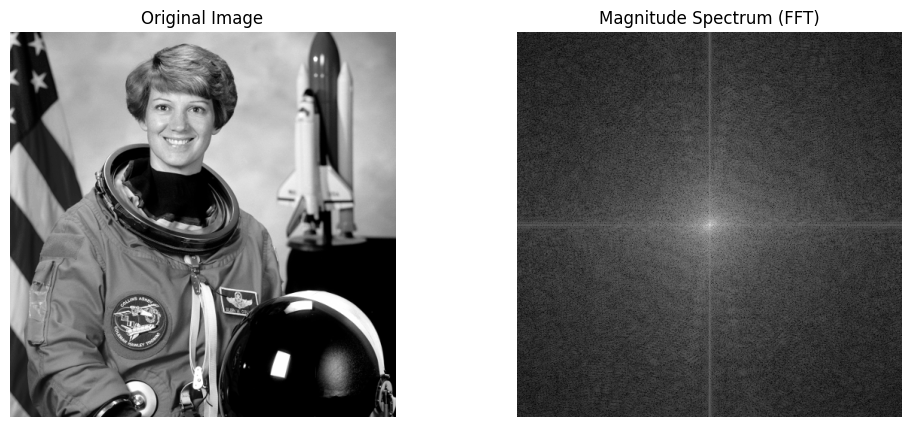

In [8]:
# --- Load a sample grayscale image ---
image = color.rgb2gray(data.astronaut())

# --- Compute 2D Fourier Transform ---
### START CODE ### (3 lines)
f = np.fft.fft2(image)            # compute FFT
fshift = np.fft.fftshift(f)       # shift zero frequency to the center
magnitude_spectrum = np.log1p(np.abs(fshift))  # log scale for visibility
### END CODE ###

# --- Display image and its spectrum ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(magnitude_spectrum, cmap="gray")
axes[1].set_title("Magnitude Spectrum (FFT)")
axes[1].axis("off")

plt.show()

> ***Expected Output:*** 2 Images

##### Step 2: Blur in Spatial Domain $\rightarrow$ Low-Pass in Frequency Domain

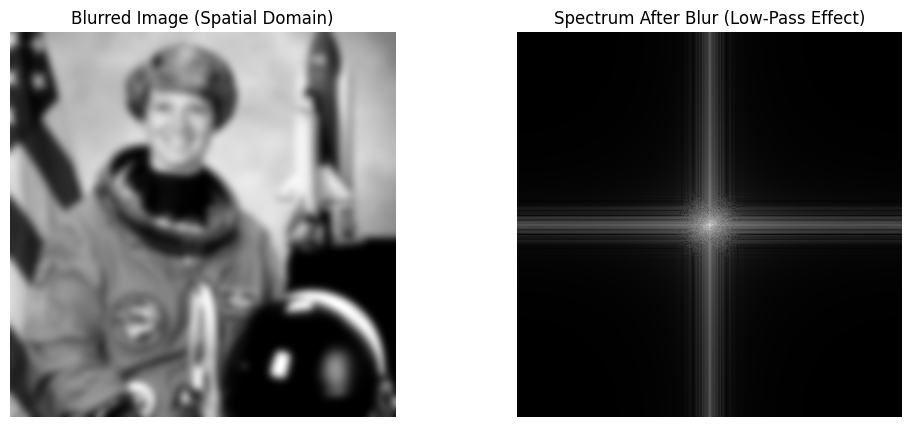

In [9]:
# --- Apply Gaussian blur to the image (spatial domain) ---
blurred = filters.gaussian(image, sigma=5)

# --- Compute FFT of blurred image ---
### START CODE ### (3 lines)
f_blur = np.fft.fft2(blurred)  # compute FFT
fshift_blur = np.fft.fftshift(f_blur)   # shift zero frequency to the center
magnitude_spectrum_blur = np.log1p(np.abs(fshift_blur))  # log scale for visibility
### END CODE ###

# --- Display blurred image and its spectrum ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(blurred, cmap="gray")
axes[0].set_title("Blurred Image (Spatial Domain)")
axes[0].axis("off")

axes[1].imshow(magnitude_spectrum_blur, cmap="gray")
axes[1].set_title("Spectrum After Blur (Low-Pass Effect)")
axes[1].axis("off")

plt.show()

> ***Expected Output:*** 2 Images

##### Step 3: Show how blurring in the spatial domain corresponds to low-pass filtering in the frequency domain.

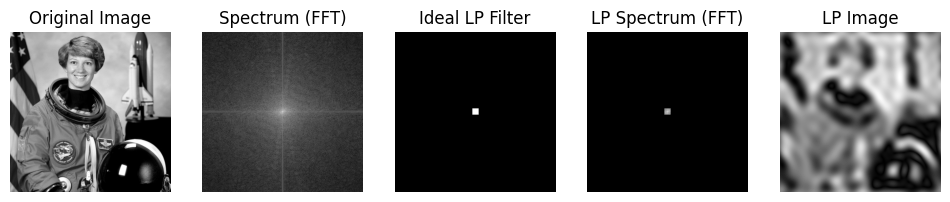

In [10]:
# --- Compute FFT of original image ---
### START CODE ### (3 lines)
f = np.fft.fft2(image)  # compute FFT
fshift = np.fft.fftshift(f)  # shift zero frequency to the center
magnitude_spectrum = np.log1p(np.abs(fshift))  # log scale for visibility
### END CODE ###

# --- Create Ideal Low-Pass Filter (white box mask) ---
rows, cols = image.shape
crow, ccol = rows // 2, cols // 2   # center of the frequency domain

radius = 10   # cutoff radius (adjust for blur strength)
### START CODE ### (1 line)
mask = np.zeros((rows, cols))
### END CODE ###
mask[crow - radius:crow + radius, ccol - radius:ccol + radius] = 1

# --- Apply mask (filtering in frequency domain) ---
### START CODE ### (2 lines)
fshift_filtered = fshift * mask
magnitude_spectrum_LP = np.log1p(np.abs(fshift_filtered))  # log scale for visibility
### END CODE ###

# --- Inverse FFT to reconstruct the filtered image ---
### START CODE ### (2 lines)
f_ishift = np.fft.ifftshift(fshift_filtered)  # shift zero frequency to the center
img_filtered = np.fft.ifft2(f_ishift)  # Inverse FFT
### END CODE ###
img_filtered = np.abs(img_filtered)

# --- Display blurred image and its spectrum ---
fig, axes = plt.subplots(1, 5, figsize=(12, 5))

plt.subplot(1, 5, 1)
axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

plt.subplot(1, 5, 2)
axes[1].imshow(magnitude_spectrum, cmap="gray")
axes[1].set_title("Spectrum (FFT)")
axes[1].axis("off")

plt.subplot(1, 5, 3)
axes[2].imshow(mask, cmap='gray')
axes[2].set_title("Ideal LP Filter")
axes[2].axis('off')

plt.subplot(1, 5, 2)
axes[3].imshow(magnitude_spectrum_LP, cmap="gray")
axes[3].set_title("LP Spectrum (FFT)")
axes[3].axis("off")

plt.subplot(1, 5, 5)
axes[4].imshow(img_filtered, cmap='gray')
axes[4].set_title("LP Image")
axes[4].axis('off')

plt.show()

> ***Expected Output:*** 5 Images

### Exercise 7: Swapping Magnitude and Phase

In the Fourier domain:  
- The **magnitude** (or amplitude) controls the strength of different frequencies.  
- The **phase** controls how those frequencies are aligned to form structures.  

In this exercise, we take two different images, compute their Fourier transforms, and then reconstruct hybrids by swapping their **magnitude** and **phase** components.

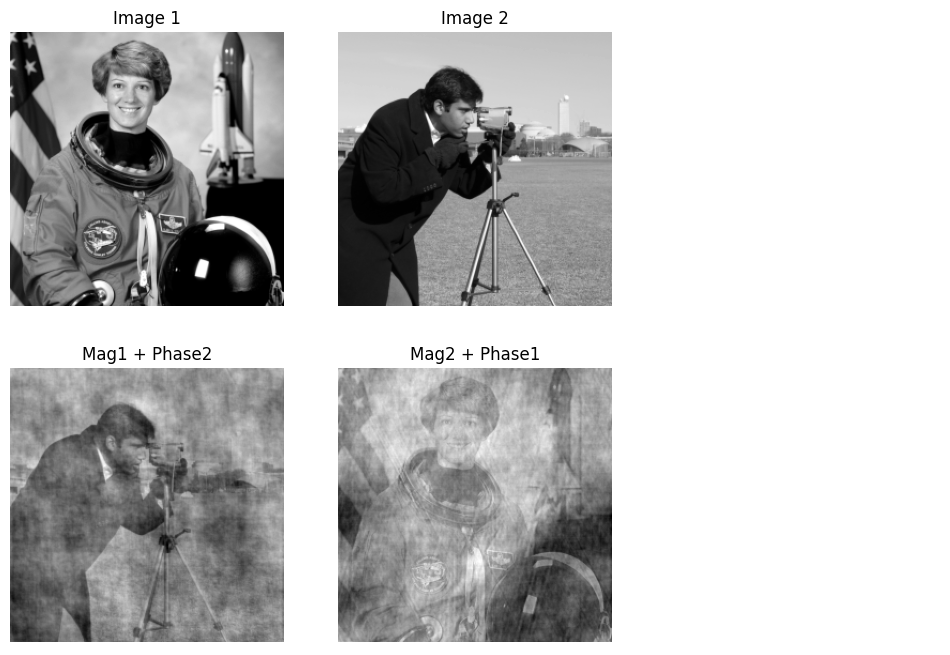

In [11]:
img1 = color.rgb2gray(data.astronaut())
img2 = data.camera()

# Resize to the same shape for FFT
shape = (256, 256)
img1 = transform.resize(img1, shape, anti_aliasing=True)
img2 = transform.resize(img2, shape, anti_aliasing=True)

# --- Compute FFTs ---
### START CODE ### (2 lines)
f1 = np.fft.fft2(img1)
f2 = np.fft.fft2(img2)
### END CODE ###

# Separate magnitude and phase
### START CODE ### (2 lines)
mag1, phase1 = np.abs(f1), np.angle(f1)
mag2, phase2 = np.abs(f2), np.angle(f2)
### END CODE ###

# --- Swap combinations ---
# Image 1's magnitude + Image 2's phase
### START CODE ### (1 line)
swap1 = np.real(np.fft.ifft2(mag1 * np.exp(1j * phase2)))
### END CODE ###

# Image 2's magnitude + Image 1's phase
### START CODE ### (1 line)
swap2 = np.real(np.fft.ifft2(mag2 * np.exp(1j * phase1)))
### END CODE ###

# --- Display results ---
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

axes[0,0].imshow(img1, cmap="gray")
axes[0,0].set_title("Image 1")
axes[0,0].axis("off")

axes[0,1].imshow(img2, cmap="gray")
axes[0,1].set_title("Image 2")
axes[0,1].axis("off")

axes[0,2].axis("off")  # empty placeholder

axes[1,0].imshow(swap1, cmap="gray")
axes[1,0].set_title("Mag1 + Phase2")
axes[1,0].axis("off")

axes[1,1].imshow(swap2, cmap="gray")
axes[1,1].set_title("Mag2 + Phase1")
axes[1,1].axis("off")

axes[1,2].axis("off")  # empty placeholder

plt.show()

> ***Expected Output:*** 4 Images

**Surprisingly, the **phase** carries most of the structural information of an image.**

Reflection (Not needed to answer):
- Which image structure dominates after swapping — the one providing magnitude or the one providing phase?  
- What does this tell us about the relative importance of phase vs. magnitude in perception? 
- Try experimenting with other image pairs. What happens when the images are very different?

## <font color='#D85658'>E. Image Derivatives</font> ##

In image processing, the **derivative** measures how pixel values change across space.  
- **First-order derivatives (gradients)** detect edges and highlight regions with rapid intensity change. 
- **Prewitt operator** detects edges by measuring intensity changes in the horizontal and vertical directions. 
- **Second-order derivatives** (like the Laplacian) capture areas where intensity changes rapidly in multiple directions.  

Key uses:  
- Edge detection  
- Feature extraction  
- Building blocks for higher-level methods (e.g., optical flow, texture analysis)  

In this section, we compute image derivatives and visualize their effects.

### Exercise 8:

##### Step 1: First-order Derivatives (Sobel Gradients)

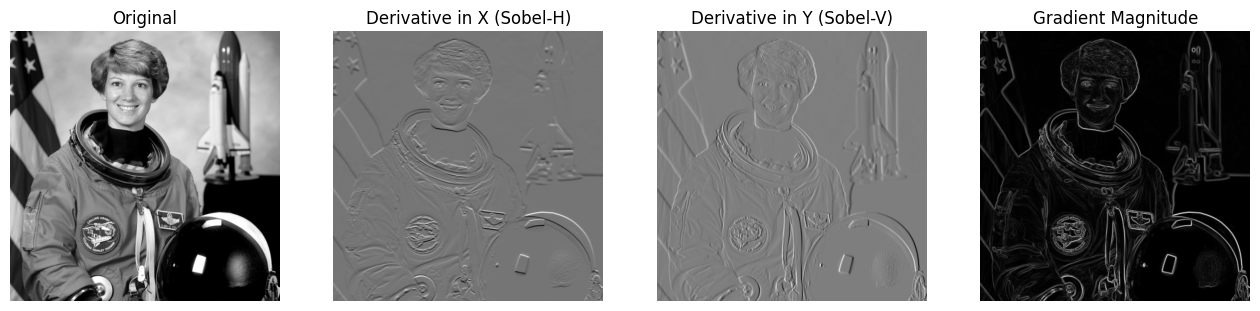

In [12]:
# --- Load grayscale image ---
image = color.rgb2gray(data.astronaut())

# --- Compute first-order derivatives using Sobel operator ---
### START CODE ### (2 lines)
grad_x = filters.sobel_h(image)   # horizontal derivative (changes along x-axis)
grad_y = filters.sobel_v(image)   # vertical derivative (changes along y-axis)
### END CODE ###

# --- Compute gradient magnitude (overall edge strength) ---
### START CODE ### (1 line)
grad_mag = np.sqrt(grad_x**2 + grad_y**2)
### END CODE ###

# --- Display results ---
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(grad_x, cmap="gray")
axes[1].set_title("Derivative in X (Sobel-H)")
axes[1].axis("off")

axes[2].imshow(grad_y, cmap="gray")
axes[2].set_title("Derivative in Y (Sobel-V)")
axes[2].axis("off")

axes[3].imshow(grad_mag, cmap="gray")
axes[3].set_title("Gradient Magnitude")
axes[3].axis("off")

plt.show()

> ***Expected Output:*** 4 Images

##### Step 2: Prewitt Filter for Image Derivatives

The **Prewitt operator** is another way to approximate image derivatives.  
The main difference: Prewitt uses uniform weights, while Sobel gives more weight to the center row/column.

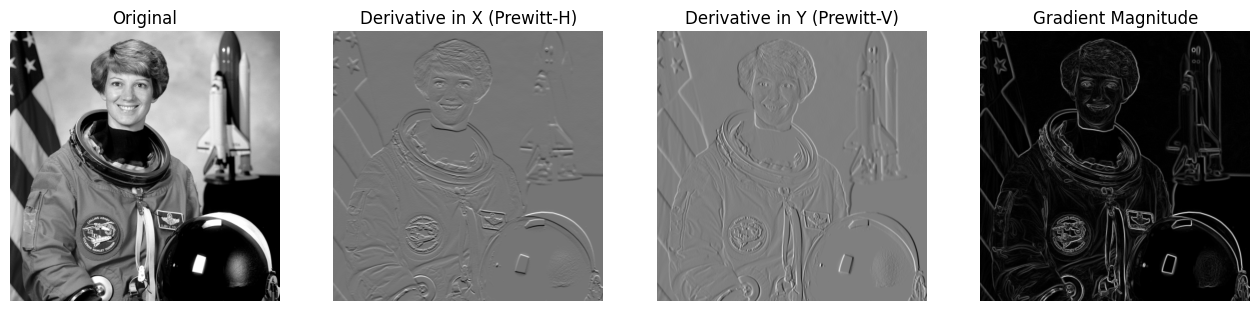

In [13]:
# --- Load grayscale image ---
image = color.rgb2gray(data.astronaut())

# --- Compute Prewitt derivatives ---
### START CODE ### (2 lines)
grad_x = filters.prewitt_h(image)   # horizontal derivative
grad_y = filters.prewitt_v(image)   # vertical derivative
### END CODE ###

# --- Gradient magnitude (edge strength) ---
### START CODE ### (1 line)
grad_mag = np.sqrt(grad_x**2 + grad_y**2)
### END CODE ###

# --- Display results ---
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(grad_x, cmap="gray")
axes[1].set_title("Derivative in X (Prewitt-H)")
axes[1].axis("off")

axes[2].imshow(grad_y, cmap="gray")
axes[2].set_title("Derivative in Y (Prewitt-V)")
axes[2].axis("off")

axes[3].imshow(grad_mag, cmap="gray")
axes[3].set_title("Gradient Magnitude")
axes[3].axis("off")

plt.show()

> ***Expected Output:*** 4 Images

##### Step 3: Second-order Derivatives (Laplacian)

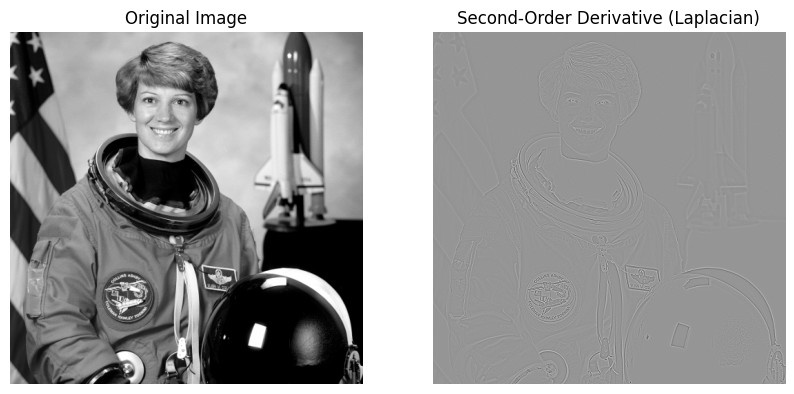

In [14]:
from scipy.ndimage import laplace

# --- Apply Laplacian filter (second-order derivative) ---
### START CODE ### (1 line)
laplacian_img = laplace(image)
### END CODE ###

# --- Display original vs Laplacian ---
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(laplacian_img, cmap="gray")
axes[1].set_title("Second-Order Derivative (Laplacian)")
axes[1].axis("off")

plt.show()

> ***Expected Output:*** 2 Images

## <font color='#D85658'>F. Blur Filters and Edge Loss</font> ##

Blurring is often used for **denoising** or **smoothing**, but it comes at a cost: it reduces high-frequency details, which means **edges become weaker or disappear**.  

To see this, we will:  
1. Apply Gaussian blur with increasing `sigma` values.  
2. Compute image derivatives (using Sobel).  
3. Compare how edge strength degrades as the blur increases.

### Exercise 9: Apply Gaussian Blur of Different Strengths

In this exercise, we apply Gaussian blur with different values of `sigma`. A higher `sigma` means stronger smoothing and more loss of detail.

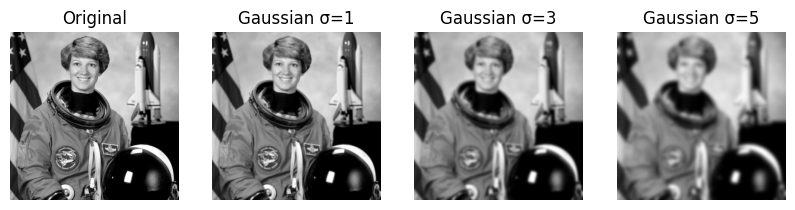

In [15]:
# --- Load grayscale image ---
image = color.rgb2gray(data.astronaut())

# --- Apply Gaussian blur with different sigma values ---
### START CODE ### (3 lines)
blur_sigma1 = filters.gaussian(image, sigma=1)  # sigma is 1
blur_sigma3 = filters.gaussian(image, sigma=3)  # sigma is 3
blur_sigma5 = filters.gaussian(image, sigma=5)  # sigma is 5
### END CODE ###

# --- Display results ---
fig, axes = plt.subplots(1, 4, figsize=(10, 5))
images = [image, blur_sigma1, blur_sigma3, blur_sigma5]
titles = ["Original", "Gaussian σ=1", "Gaussian σ=3", "Gaussian σ=5"]

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

plt.show()

> ***Expected Output:*** 4 Images

### Exercise 10: Compare Edge Strength After Blur

Here, we compute Sobel edge maps of the blurred images. As `sigma` increases, edges become weaker, showing the loss of high-frequency information.

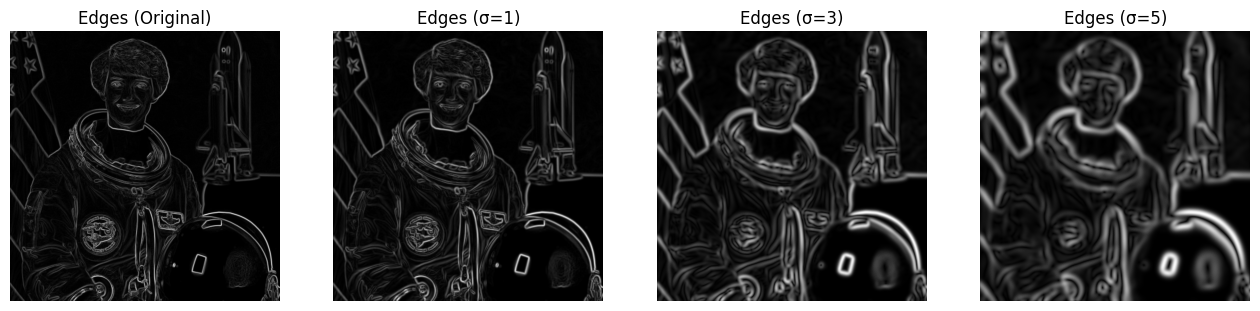

In [16]:
# --- Compute Sobel gradient magnitude for each version ---
### START CODE ### (3 lines)
def sobel_magnitude(img):
    grad_x = filters.sobel_h(img)
    grad_y = filters.sobel_v(img)
    return np.sqrt(grad_x**2 + grad_y**2)
### END CODE ###

edges_original = sobel_magnitude(image)
edges_sigma1 = sobel_magnitude(blur_sigma1)
edges_sigma3 = sobel_magnitude(blur_sigma3)
edges_sigma5 = sobel_magnitude(blur_sigma5)

# --- Display edge maps side by side ---
fig, axes = plt.subplots(1, 4, figsize=(16, 5))
edge_maps = [edges_original, edges_sigma1, edges_sigma3, edges_sigma5]
titles = ["Edges (Original)", "Edges (σ=1)", "Edges (σ=3)", "Edges (σ=5)"]

for ax, img, title in zip(axes, edge_maps, titles):
    ax.imshow(img, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

plt.show()

> ***Expected Output:*** 4 Images

## <font color='#D85658'>G. Temporal Filters (Video)</font> ##

So far, we have applied filters in the **spatial domain** (within one image). For videos, we can also filter across **time** to process sequences of frames.  

Two common operations are:  
1. **Frame differencing** – detect motion by subtracting consecutive frames.
2. **Temporal low-pass filtering** – smooth pixel values across frames to reduce flicker or noise.

### Exercise 11: Frame Differencing for Motion Detection

In this exercise, we simulate motion by shifting an image across frames. By subtracting consecutive frames, we highlight regions that change — which corresponds to motion.

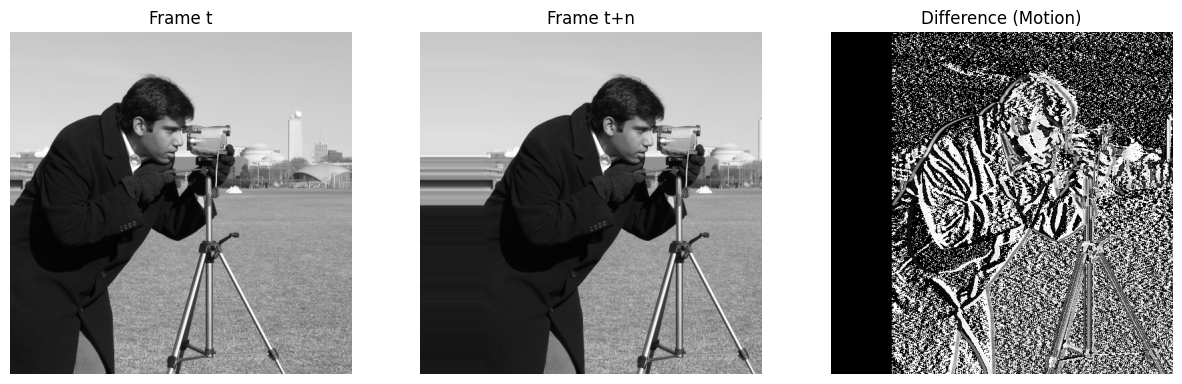

In [17]:
from scipy.ndimage import shift

# --- Create a synthetic video sequence (moving image) ---
base = data.camera()
n = 20  # number of frames
idx = 19  # index of the frame for visualization
### START CODE ### (1 line)
frames = [shift(base, shift=(0, i*5), mode='nearest') for i in range(n)]  # shift right by 5 pixels each frame 
### END CODE ###

# --- Compute frame differences (motion detection) ---
### START CODE ### (1 line)
diffs = [np.abs(frames[i+1] - frames[i]) for i in range(len(frames)-1)]
### END CODE ###

# --- Display one example pair of frames and their difference ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(frames[1], cmap="gray")
axes[0].set_title("Frame t")
axes[0].axis("off")

axes[1].imshow(frames[idx], cmap="gray")
axes[1].set_title("Frame t+n")
axes[1].axis("off")

axes[2].imshow(diffs[idx-1], cmap="gray")
axes[2].set_title("Difference (Motion)")
axes[2].axis("off")

plt.show()

> ***Expected Output:*** 3 Images

👉 **Instruction for Students**  
You can experiment with your **own short video** (e.g., a few seconds of people moving or objects in motion).  

1. Upload the video file into your notebook environment (e.g., drag-and-drop in Colab or Jupyter).  
2. Use the `imageio` library to read the video into a list of frames.  
3. Apply the frame differencing code to detect motion between consecutive frames.  

Example snippet to read video frames:  

```python
import imageio

# --- Load video into a list of grayscale frames ---
reader = imageio.get_reader("your_video.mp4")
frames = []
for frame in reader:
    gray = np.dot(frame[...,:3], [0.299, 0.587, 0.114])  # convert to grayscale
    frames.append(gray)
reader.close()

print(f"Loaded {len(frames)} frames from video")


### Exercise 12: Temporal Low-Pass Filtering to Reduce Flicker

Here, we reduce flicker by averaging frames over time. This is like a low-pass filter in the temporal domain — it keeps slow changes while suppressing fast changes (flicker, noise).

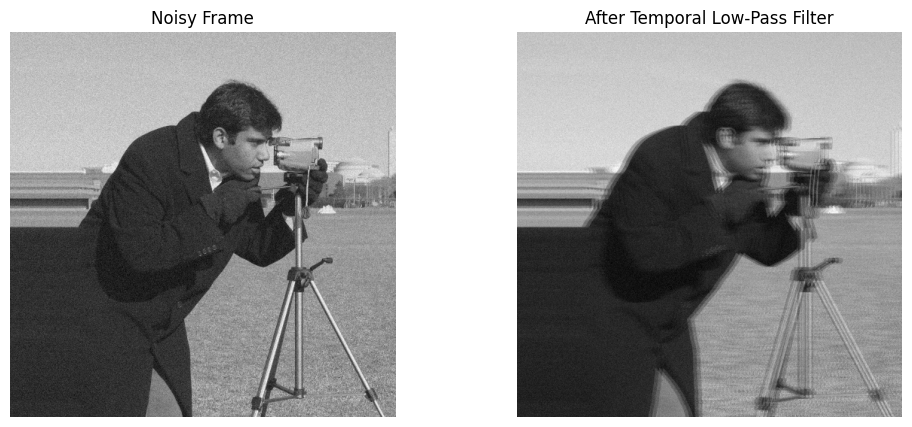

In [18]:
# --- Create a synthetic noisy video sequence ---
n = 20  # number of frames
idx = 18  # index of the frame for visualization
rng = np.random.default_rng(0)
### START CODE ### (1 line)
noisy_frames = [shift(data.camera(), shift=(0, i*5), mode='nearest') + rng.normal(0, 10, data.camera().shape) for i in range(n)]  # shift right by 5 pixels each frame (base + Gaussian noise)
### END CODE ###

# --- Temporal low-pass filter: simple moving average ---
smoothed_frames = []
for i in range(len(noisy_frames)):
    # Average current frame with its neighbors (window size = 3)
    ### START CODE ### (2 lines)
    start, end = max(0, i-1), min(len(noisy_frames), i+2)
    smoothed = np.mean(noisy_frames[start:end], axis=0)
    ### END CODE ###
    smoothed_frames.append(smoothed)

# --- Display one noisy frame vs. its smoothed version ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(noisy_frames[idx], cmap="gray")
axes[0].set_title("Noisy Frame")
axes[0].axis("off")

axes[1].imshow(smoothed_frames[idx], cmap="gray")
axes[1].set_title("After Temporal Low-Pass Filter")
axes[1].axis("off")

plt.show()


> ***Expected Output:*** 2 Images

## <font color='#D85658'>H. Exercises</font> ##

In this final section, you will implement and experiment with **custom filters**. The goal is to understand how different kernels affect images, and to creatively design your own filters.

- Implement a custom filter kernel.
- Explore sharpening (unsharp mask).
- Design a filter that removes horizontal vs. vertical patterns.

### Exercise 13: Implement a Custom Filter Kernel

In this exercise, you will define your own $3\times3$ kernel and apply convolution manually. Try designing a blur kernel, edge detector, or emboss effect.

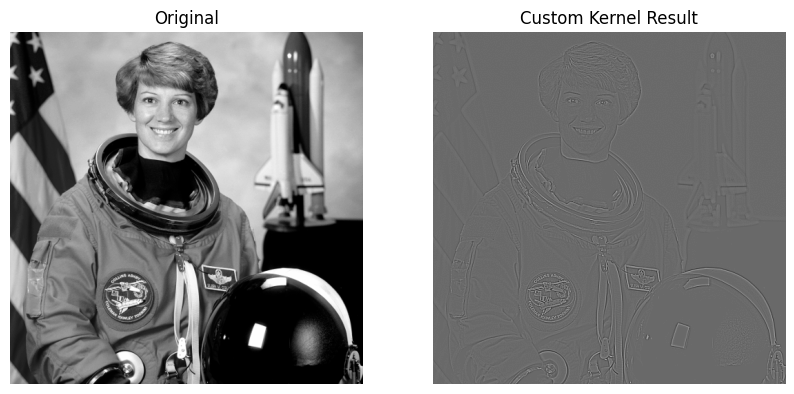

In [19]:
# --- Load grayscale image ---
image = color.rgb2gray(data.astronaut())

# --- TODO: Define your own kernel (3x3 or 5x5) ---
# Example: simple edge detection
### START CODE ### (1 line)
custom_kernel = np.array([[ -1, -1, -1],
                          [ -1,  8, -1],
                          [ -1, -1, -1]])
### END CODE ###

# --- Apply convolution with your kernel ---
filtered = convolve2d(image, custom_kernel, mode='same', boundary='symm')

# --- Show results ---
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(filtered, cmap="gray")
axes[1].set_title("Custom Kernel Result")
axes[1].axis("off")

plt.show()

> ***Expected Output:*** 2 Images

### Exercise 14: Sharpening with Unsharp Mask

Sharpening enhances edges by adding back details lost in smoothing. The unsharp mask works by subtracting a blurred version of the image from the original, then adding this difference back.

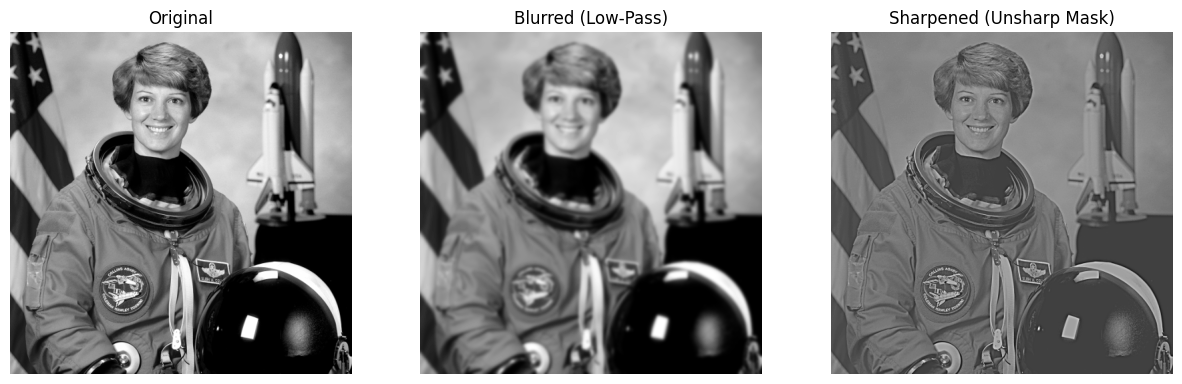

In [20]:
# --- Blur the image (low-pass) ---
blurred = filters.gaussian(image, sigma=2)

# --- Compute the mask (original - blurred) ---
### START CODE ### (1 line)
mask = image - blurred
### END CODE ###

# --- Create sharpened image: original + amount * mask ---
### START CODE ### (1 line)
sharpened = image + 1.5 * mask
### END CODE ###

# --- Show results ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(blurred, cmap="gray")
axes[1].set_title("Blurred (Low-Pass)")
axes[1].axis("off")

axes[2].imshow(sharpened, cmap="gray")
axes[2].set_title("Sharpened (Unsharp Mask)")
axes[2].axis("off")

plt.show()

> ***Expected Output:*** 3 Images

### Exercise 15: Design Filters for Horizontal vs. Vertical Patterns
Here, you will design filters that suppress patterns in one direction.
- Use a horizontal edge detector (emphasizes horizontal lines, suppresses vertical).
- Use a vertical edge detector (emphasizes vertical lines, suppresses horizontal).

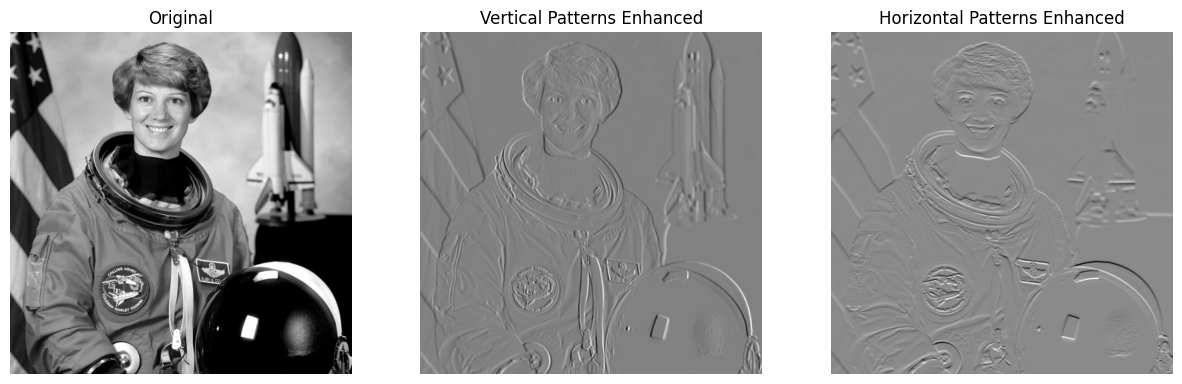

In [21]:
# --- Define directional kernels ---
# Detect vertical structures (suppress horizontal)
### START CODE ### (1 line)
kernel_vertical = np.array([[-1, 0, 1],
                            [-2, 0, 2],
                            [-1, 0, 1]])
### END CODE ###

# Detect horizontal structures (suppress vertical)
### START CODE ### (1 line)
kernel_horizontal = np.array([[-1, -2, -1],
                              [ 0,  0,  0],
                              [ 1,  2,  1]])
### END CODE ###

# --- Apply convolutions ---
filtered_vertical = convolve2d(image, kernel_vertical, mode='same', boundary='symm')
filtered_horizontal = convolve2d(image, kernel_horizontal, mode='same', boundary='symm')

# --- Show results ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image, cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(filtered_vertical, cmap="gray")
axes[1].set_title("Vertical Patterns Enhanced")
axes[1].axis("off")

axes[2].imshow(filtered_horizontal, cmap="gray")
axes[2].set_title("Horizontal Patterns Enhanced")
axes[2].axis("off")

plt.show()

> ***Expected Output:*** 3 Images

## <font color='#D85658'>I. Discussion/Reflection</font> ##

* <u>How do blur, noise, and filtering interact?</u>

Answer:  
The blur smooths intensity variations (reduces high-frequency content) and helps reduce noise but also softens edges. Whereas, the noise in images makes edges and details less clear (we saw two types of random pixel variations → Gaussian noise, salt-and-pepper noise). Finally, for filtering, low-pass filters (Gaussian, mean/box filter) reduce noise and smooth image, high-pass filters (derivatives, Sobel, Laplacian) enhance edges but are sensitive to noise. It's a trade-off between noise reduction and edge preservation.


* <u>Why do edges appear clearly in derivative filters but vanish with blur?</u>

Answer:  
It appears because derivative filters (Sobel, Prewitt, Laplacian) compute changes in intensity (highlight rapid changes) for edges' detection. Also, with the use of first-order derivatives for edge orientation, and of second-order derivatives in order to detect rapid changes in multiple directions. Whereas, the blur smooths intensity transitions (reduces gradient magnitude) and the edges become less steep, so the derivatives produce smaller values, then it's less visible edges.